In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import time

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# If you use GPU, the device should be cuda
#device = 'cpu'
print('Using device:', device)

Using device: cpu


In [3]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))



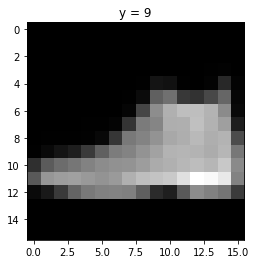

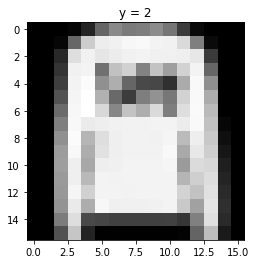

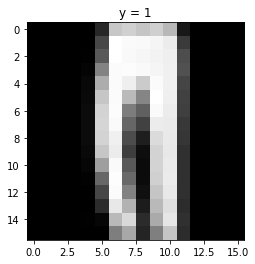

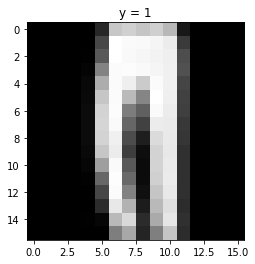

In [5]:
IMAGE_SIZE = 16

############# Your code here ############
## Note:
##1. Create a transform to resize image to IMAGE_SIZE and convert to tensor
##(~ 1 line of code)
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
#########################################

# Create Dataset from MNIST and apply composed transformation
dataset_train = dsets.FashionMNIST(root='.fashion/data', train=True, download=True, transform=composed)
dataset_val = dsets.FashionMNIST(root='.fashion/data', train=False, download=True, transform=composed)

for n, data_sample in enumerate(dataset_val):

    show_data(data_sample)
    plt.show()
    if n == 2:
        break


show_data(dataset_val[0])
show_data(dataset_val[1])
show_data(dataset_val[2])


In [6]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=100)
test_dataloader = DataLoader(dataset=dataset_val, batch_size=100)

In [7]:
class CNN(nn.Module):

    # Constructor
    def __init__(self, out_ch, hidden_dim):
        super().__init__()
        ############# Your code here ############
        ## Note:
        ##1. Define a Network Convolution(in_channels=1, out_channels=out_ch,kernel_size=5,padding=2) followed by Batchnorm
        ##2. Pass the ouput through a linear classifier with 1 hidden layer with channels=hidden_dim
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=out_ch, kernel_size=5, padding=2),#Image is 2D
                                  nn.BatchNorm2d(out_ch),#Image is 2D
                                 )
        
        
        self.LC = nn.Sequential(nn.Linear(out_ch*8*8, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, 10))
        
        #########################################
                                

    # Prediction
    def forward(self, x):
        print("input shape",x.shape)
        x = self.cnn(x)
        print('after cnn',x.shape)
        x = x.view(x.size(0), -1)
        #print('bef LC',x.shape)
        x = self.LC(x)
        return x

In [8]:
args = {
    'device': device,
    'out_ch':16,
    'hidden_dim': 512,
    'ouput_dim':10,
    'dropout': 0.2,
    'lr': 0.01,
    'epochs': 10,
}
args

{'device': device(type='cpu'),
 'out_ch': 16,
 'hidden_dim': 512,
 'ouput_dim': 10,
 'dropout': 0.2,
 'lr': 0.01,
 'epochs': 10}

In [9]:
############# Your code here ############
## Note:
## 1. Set model to custom class with appropriate inputs
## 2. Print the model
##(~2 lines of code)
model = CNN(out_ch=args['out_ch'], hidden_dim=args['hidden_dim']).to(device)
print(model)
#########################################
next(model.parameters()).device 

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (LC): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


device(type='cpu')

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer,dev):
    # TODO: Implement this function that trains the model by 
    # using the given optimizer and loss_fn.
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #Shifting data to device
        X,y= X.to(dev),y.to(dev)
        
        ############# Your code here ############
        ## Note:
        ## 1. Zero grad the optimizer
        ## 2. Feed the data into the model
        ## 3. Calculate the loss fn using output and label
        ## 4. Implement Backpropagation
        ## (~5 lines of code)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        #########################################

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [11]:
def test_loop(dataloader, model, loss_fn,dev):
    # The output of model on all data
    # TODO: Implement this function that tests the model
  
    model.eval()

    # The output of model on all data
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            #Shifting data to device
            X,y= X.to(dev),y.to(dev)
            ############# Your code here ############
            ## Note:
            ## Calculate the ouptut
            ## (~1 line of code)
            pred = model(X)
            #########################################
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    #print("size",size)
    #print("before returning corr",correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct


In [12]:
%%time
import copy

############# Your code here ############
## Note:
## 1.Set the loss_fn to CE Loss
##2.Set the optimizer
##(~2 lines of code)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'])
#########################################

best_model = None
best_test_acc = 0


for t in range(args['epochs']):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,device)
    test_acc=test_loop(test_dataloader, model, loss_fn,device)
    
    ############# Your code here ############
    ## Note:
    ##1.Set a condition to determine the best_test_acc
    ##2. Using copy.deepcopy() save the best_model
    ##(~3 lines of code)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model = copy.deepcopy(model)
    #########################################
print("Done!")


Epoch 1
-------------------------------
input shape torch.Size([100, 1, 16, 16])
after cnn torch.Size([100, 16, 16, 16])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x4096 and 1024x512)